In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.formula.api as smf
%matplotlib inline

In [7]:
%%bash

res_dir="/media/veracrypt1/Analysis/ASL/results/1/"
# second graph is 23 42 38
# fslmaths ${res_dir}/smoothed/tstats2_corrected_1.nii.gz -mul 0 -add 1 -roi 23 1 72 1 46 1 0 1 ${res_dir}/sphere2/point2 -odt float
fslmaths ${res_dir}/smoothed/tstats2_corrected_1.nii.gz -mul 0 -add 1 -roi 23 1 42 1 38 1 0 1 ${res_dir}/sphere2/point2 -odt float

fslmaths ${res_dir}/sphere2/point2 -bin ${res_dir}/sphere2/point2_bin 
fslmaths ${res_dir}/sphere2/point2 -kernel sphere 4 -fmean ${res_dir}/sphere2/sphere2 -odt float
fslmaths ${res_dir}/sphere2/sphere2 -bin ${res_dir}/sphere2/sphere2_bin

In [8]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import time
import nibabel as nib
import os, errno
import parmap


model = "1"

main_dir = "/media/veracrypt1/Analysis/ASL/cbf2mni/"
res_dir = "/media/veracrypt1/Analysis/ASL/results/"+model+"/sphere2/"
preproc_dir = "/home/dmitrii/repos/ASL_longitudinal/data_selection/"

brain_file = main_dir + "2mm/cbf_all_2mm_inc_find_removed.nii.gz"
cbf_all = nib.load(brain_file).get_data()

# cbf_mask = "/media/veracrypt1/Analysis/ASL/MNI/gm_mask_2mm.nii.gz" # grey matter mask binirized and thresholded at .1
cbf_mask = "/media/veracrypt1/Analysis/ASL/results/1/sphere2/point2_bin.nii.gz"
cbf_mask_array = nib.load(cbf_mask).get_data()

df = pd.read_csv("../predictors_inc_find_removed.csv", sep='\t')

print("Starting analysis...")

"""
Create an array to store coordinates
"""
print("Extracting coordinates from the mask")
def coord_extract(mask_array):

    d0,d1,d2 = np.where(mask_array>0)
    coord_array = np.zeros((len(d0), 3), dtype=int)
    coord_array[:,0] = d0
    coord_array[:,1] = d1
    coord_array[:,2] = d2

    return coord_array

coord_array = coord_extract(cbf_mask_array)
print("Total voxels", len(coord_array))


"""
Main analysis function
"""

def analyze(crow):

    d0, d1, d2 = coord_array[crow,:]

    df['cbf'] = cbf_all[d0,d1,d2,:]

    # drop zero voxel from the analysis
    # these are the voxels that are masked out or improperly aligned
    # save as a new df
    df_clean = df[df.cbf > 0]

    if len(df_clean) > 0:

        # run linear regression, the intercept and the random intercept are done by default
        res1 = sm.MixedLM.from_formula("cbf ~ Age * C(Male) + Brain_vol", data=df_clean, missing='drop', groups=df_clean["Subj_id"]).fit(reml=True)

        res1_0_beta = res1.params[0] # intercept
        res1_1_beta = res1.params[1] # sex
        res1_2_beta = res1.params[2] # age
        res1_3_beta = res1.params[3]  # interaction
        res1_4_beta = res1.params[4]  # brain volume
        res1_5_beta = res1.params[5]  # right hand
        res1_llf = res1.llf
        
#         print(res1.summary())

    else:
        res1_0_beta = 0
        res1_1_beta = 0
        res1_2_beta = 0
        res1_3_beta = 0
        res1_4_beta = 0
        res1_5_beta = 0
        res1_llf = None

    return [d0, d1, d2, res1_0_beta, res1_1_beta, res1_2_beta, res1_3_beta, res1_4_beta, res1_5_beta]


def save_res(results):

    """
    Create arrays to store beta-,t-,p-values
    Iterate through each voxel and do regressions
    """
    beta0_values_array = np.zeros((cbf_mask_array.shape), dtype=float)
    beta1_values_array = np.zeros((cbf_mask_array.shape), dtype=float)
    beta2_values_array = np.zeros((cbf_mask_array.shape), dtype=float)
    beta3_values_array = np.zeros((cbf_mask_array.shape), dtype=float)
    beta4_values_array = np.zeros((cbf_mask_array.shape), dtype=float)
    beta5_values_array = np.zeros((cbf_mask_array.shape), dtype=float)

    print("Saving the results")

    for i in range(len(results)):
        d0, d1, d2, res1_0_beta, res1_1_beta, res1_2_beta, res1_3_beta, res1_4_beta, res1_5_beta = results[i]

        beta0_values_array[d0, d1, d2] = res1_0_beta
        beta1_values_array[d0, d1, d2] = res1_1_beta
        beta2_values_array[d0, d1, d2] = res1_2_beta
        beta3_values_array[d0, d1, d2] = res1_3_beta
        beta4_values_array[d0, d1, d2] = res1_4_beta
        beta5_values_array[d0, d1, d2] = res1_5_beta

    values_img = nib.Nifti1Image(beta0_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas0.nii.gz"))
    
    values_img = nib.Nifti1Image(beta1_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas1.nii.gz"))

    values_img = nib.Nifti1Image(beta2_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas2.nii.gz"))

    values_img = nib.Nifti1Image(beta3_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas3.nii.gz"))
    
    values_img = nib.Nifti1Image(beta4_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas4.nii.gz"))
    
    values_img = nib.Nifti1Image(beta5_values_array, np.eye(4))
    nib.save(values_img, os.path.join(res_dir, "betas5.nii.gz"))

def pm_err():
    print("Something went wrong with the parmap")

print("Starting regression analyses...")
start_time = time.time()
from multiprocessing import Pool

with Pool(12) as pool:
    results = pool.map(analyze, list(range(len(coord_array))))

print("--- Regression is done in %s seconds ---" % (time.time() - start_time))

save_res(results)


/home/dmitrii/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Starting analysis...
Extracting coordinates from the mask
Total voxels 1
Starting regression analyses...
--- Regression is done in 0.4005870819091797 seconds ---
Saving the results


In [9]:
# This is for the plot

import numpy as np
import statsmodels.api as sm
import pandas as pd
import time
import nibabel as nib
import os, errno
import parmap


model = "1"

main_dir = "/media/veracrypt1/Analysis/ASL/cbf2mni/"
res_dir = "/media/veracrypt1/Analysis/ASL/results/"+model+"/sphere2/"
preproc_dir = "/home/dmitrii/repos/ASL_longitudinal/data_selection/"

brain_file = main_dir + "2mm/cbf_all_2mm_inc_find_removed.nii.gz"
cbf_all = nib.load(brain_file).get_data()

# cbf_mask = "/media/veracrypt1/Analysis/ASL/MNI/gm_mask_2mm.nii.gz" # grey matter mask binirized and thresholded at .1
cbf_mask = "/media/veracrypt1/Analysis/ASL/results/1/sphere2/point2_bin.nii.gz"
cbf_mask_array = nib.load(cbf_mask).get_data()

df = pd.read_csv("../predictors_inc_find_removed.csv", sep='\t')

print("Starting analysis...")

"""
Create an array to store coordinates
"""
print("Extracting coordinates from the mask")
def coord_extract(mask_array):

    d0,d1,d2 = np.where(mask_array>0)
    coord_array = np.zeros((len(d0), 3), dtype=int)
    coord_array[:,0] = d0
    coord_array[:,1] = d1
    coord_array[:,2] = d2

    return coord_array

coord_array = coord_extract(cbf_mask_array)
print("Total voxels", len(coord_array))


"""
Main analysis function
"""

def analyze(crow, df):

    d0, d1, d2 = coord_array[crow,:]

    cbf = cbf_all[d0,d1,d2,:]
    
    df = df[["Subj_id", "Age", "Age_cent", "Male", "Brain_vol", "R_Hand"]]
    df["cbf"] = cbf
    print(df.columns)
    df.to_csv(res_dir+"df.csv",index=None,sep='\t',header=None)

analyze(0, df)


Starting analysis...
Extracting coordinates from the mask
Total voxels 1
Index(['Subj_id', 'Age', 'Age_cent', 'Male', 'Brain_vol', 'R_Hand', 'cbf'], dtype='object')


/home/dmitrii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
%%bash

res_dir="/media/veracrypt1/Analysis/ASL/results/1/sphere2/"
main_dir="/media/veracrypt1/Analysis/ASL/"
cbf_file=${main_dir}"cbf2mni/2mm/cbf_all_2mm_inc_find_removed.nii.gz"
inercept_file=${res_dir}"betas0.nii.gz"
age_file=${res_dir}"betas2.nii.gz"
male_file=${res_dir}"betas1.nii.gz"
bv_file=${res_dir}"betas4.nii.gz"

mask_file="point2_bin.nii.gz"

fslstats -t ${cbf_file} -k ${res_dir}${mask_file} -M > ${res_dir}cbf_means.txt
fslstats -t ${inercept_file} -k ${res_dir}${mask_file} -M > ${res_dir}int_means.txt
fslstats -t ${age_file} -k ${res_dir}${mask_file} -M > ${res_dir}age_means.txt
fslstats -t ${male_file} -k ${res_dir}${mask_file} -M > ${res_dir}male_means.txt
fslstats -t ${bv_file} -k ${res_dir}${mask_file} -M > ${res_dir}bv_means.txt

/home/dmitrii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


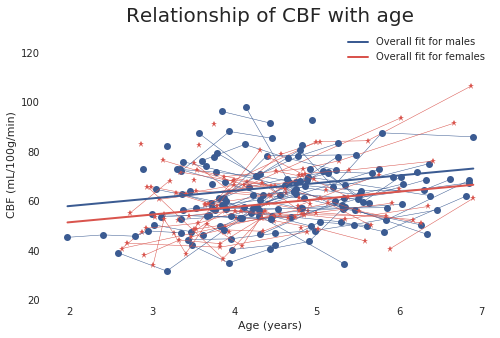

In [13]:
from matplotlib.lines import Line2D

res_dir="/media/veracrypt1/Analysis/ASL/results/1/sphere2/"
repos_dir="/home/dmitrii/repos/ASL_longitudinal/analyses/"

cbf=np.loadtxt(res_dir+"cbf_means.txt")
df=pd.read_csv(repos_dir+"predictors_inc_find_removed.csv", sep='\t')
df['cbf']=cbf

#now construct the fit line from brain results
beta0=np.mean(np.loadtxt(res_dir+"int_means.txt"))
beta1=np.mean(np.loadtxt(res_dir+"male_means.txt"))
beta2=np.mean(np.loadtxt(res_dir+"age_means.txt"))
beta4=np.mean(np.loadtxt(res_dir+"bv_means.txt"))
x=np.array([np.min(df.Age),np.max(df.Age)])
brain_vol = np.min(df.Brain_vol)
y1=beta0+beta1+beta2*x+beta4*brain_vol  # males
y2=beta0+beta2*x+beta4*brain_vol  # females

plt.rcParams["figure.figsize"] = [8, 5]

df2 = pd.read_csv("/media/veracrypt1/Analysis/ASL/results/1/sphere2/df.csv", header=None,sep='\t')
df2.columns = ['Subj_id', 'Age', 'Age_cent', 'Male', 'Brain_vol', 'R_Hand', 'cbf']
df2['cbf_mean'] = df2['cbf']
for sid in pd.unique(df2.Subj_id):
    
    if len(df2[df2.Subj_id == sid]) > 1:
        lm = smf.ols("cbf ~ Age + C(Male) + Brain_vol",data=df2[df2.Subj_id == sid]).fit()
#         print(lm.summary())
        X = df2[['Age', 'Male', 'Brain_vol']][df2.Subj_id == sid]
        df2.cbf_mean[df2.Subj_id == sid] = lm.predict(X)
        plt.plot(df2.Age[(df2.Male==1) & (df2.Subj_id == sid)],df2.cbf_mean[(df2.Male==1) & (df2.Subj_id == sid)],'o-', color=sns.xkcd_rgb["denim blue"], linewidth=.5)
        plt.plot(df2.Age[(df2.Male==0) & (df2.Subj_id == sid)],df2.cbf_mean[(df2.Male==0) & (df2.Subj_id == sid)],'*-', color=sns.xkcd_rgb["pale red"], linewidth=.5)
    else:
        plt.plot(df2.Age[(df2.Male==1) & (df2.Subj_id == sid)],df2.cbf[(df2.Male==1) & (df2.Subj_id == sid)],'o', color=sns.xkcd_rgb["denim blue"], linewidth=.5)
        plt.plot(df2.Age[(df2.Male==0) & (df2.Subj_id == sid)],df2.cbf[(df2.Male==0) & (df2.Subj_id == sid)],'*', color=sns.xkcd_rgb["pale red"], linewidth=.5)

plt.plot(x,y1,'-', color=sns.xkcd_rgb["denim blue"], linewidth=2)
plt.plot(x,y2,'-', color=sns.xkcd_rgb["pale red"], linewidth=2)

custom_lines = [Line2D([0], [0], color=sns.xkcd_rgb["denim blue"], lw=2),
                Line2D([0], [0], color=sns.xkcd_rgb["pale red"], lw=2)]

plt.title("Relationship of CBF with age", fontsize=20)
plt.xlabel('Age (years)')
plt.ylabel('CBF (mL/100g/min)')
plt.ylim(20,130)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# plt.show()
# plt.savefig('cbf_vs_age_right_point.png', dpi=300)
plt.savefig('cbf_vs_age_left_point.png', dpi=300)
